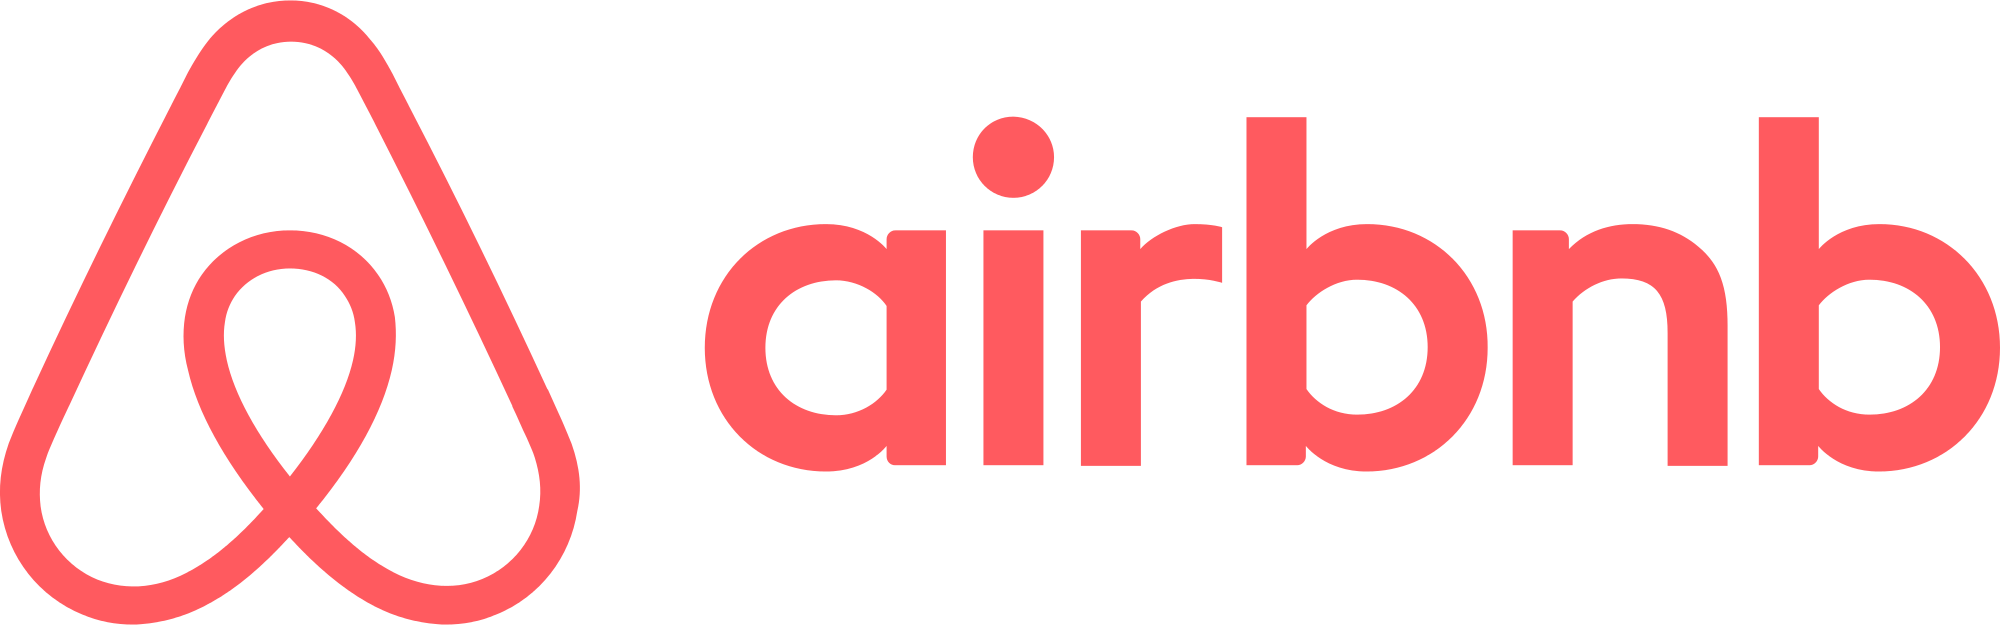
---

The objective will be to load the data, clean and format it, before exploring


and analyzing it.

We will trying to answer the following problems:    

* Q1 : Is the average price difference between "entire home" and "private room" properties significant?
* Q2: Does a host's response time affect its final review score?
* Q3 :Price trend analysis: are hosts taking advantage of the calendar to set their prices?

# Data Description

Data collected on the Airbnb website on September 9, 2022.

Detailed description:
- **calendar**: Table gathering reservation calendar information. Contains prices and availability for coming year.
    - *listing_id*: id of the accommodation
    - *date*: day of possible reservation
    - *available*: availability/unavailability of the accommodation
    - *price*: price according to the day
- **listing**: Table with an overview of the accommodations.
    - *id* : Airbnb's unique identifier for the listing (accomodation)
    - *host_response_time* : The average response time of the host for this accommodation
    - *room_type* : Entire home/apt | Private room | Shared room
    - *review_scores_value* : The average reviews score that the listing has

# Importation of data

In [1]:
import pandas as pd

In [2]:
df_calendar = pd.read_csv("calendar.csv")

In [3]:
df_calendar.head(10)

,listing_id,date,available,price
0,130420,2022-09-10,f,$220.00
1,130420,2022-09-11,f,$210.00
2,130420,2022-09-12,t,$210.00
3,130420,2022-09-13,t,$210.00
4,130420,2022-09-14,t,$210.00
5,130420,2022-09-15,f,$210.00
6,130420,2022-09-16,f,$220.00
7,130420,2022-09-17,f,$220.00
8,130420,2022-09-18,f,$210.00
9,130420,2022-09-19,f,$210.00


In [4]:
df_listing = pd.read_csv("listing.csv")

In [5]:
df_listing.head(10)

,id,room_type,host_response_time,review_scores_value
0,130420,Entire home/apt,within a few hours,4.43
1,23441,Entire home/apt,within a day,4.64
2,5396,Entire home/apt,within an hour,4.54
3,7397,Entire home/apt,within an hour,4.72
4,24260,Entire home/apt,within a few hours,4.64
5,137112,Entire home/apt,within an hour,4.61
6,26562,Entire home/apt,within a day,4.98
7,137857,Entire home/apt,within an hour,4.55
8,138548,Entire home/apt,within a few hours,4.79
9,139074,Entire home/apt,within a day,4.85


# Cleaning and formatting

## Date

In [6]:
# The "date" column is formatted as a "string" then we use the to_datetime function, to transform the "date" column to datetime format

df_calendar['date'] = pd.to_datetime(df_calendar['date'])

In [7]:
# We have also added a month column

df_calendar['month']=df_calendar['date'].dt.month

In [8]:
df_calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72101 entries, 0 to 72100
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   listing_id  72101 non-null  int64         
 1   date        72101 non-null  datetime64[ns]
 2   available   72101 non-null  object        
 3   price       72101 non-null  object        
 4   month       72101 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 2.8+ MB


In [9]:
df_calendar.head()

,listing_id,date,available,price,month
0,130420,2022-09-10,f,$220.00,9
1,130420,2022-09-11,f,$210.00,9
2,130420,2022-09-12,t,$210.00,9
3,130420,2022-09-13,t,$210.00,9
4,130420,2022-09-14,t,$210.00,9


## Price

In [10]:
# The "price" column is in a particular format
# We will create a function clean_price, which takes as input a variable "price" in the format seen above, and returns the price in float format.

def clean_price(price):
  price_clean = price.replace('$', '').replace(",",'')
  price_clean = float(price_clean)
  return price_clean

In [11]:
df_calendar["price"] = df_calendar["price"].apply(clean_price)
df_calendar["price"]

0        220.0
1        210.0
2        210.0
3        210.0
4        210.0
         ...  
72096    100.0
72097    100.0
72098    100.0
72099    100.0
72100    100.0
Name: price, Length: 72101, dtype: float64

# Data exploration

The objective of this part is to discover the data and answer the questions.

In [12]:
import plotly.express as px

In [17]:
# Oldest and most recent reservation date.

oldest = df_calendar['date'].min()
most_recent = df_calendar['date'].max()
f'The oldest reservation date is {oldest} and the most recent is {most_recent} '

'The oldest reservation date is 2022-09-09 00:00:00 and the most recent is 2023-01-31 00:00:00 '

In [14]:
# Number of unique "listing_id"

len(pd.unique(df_calendar['listing_id']))

500

In [15]:
# Descriptive statistics of price column

df_calendar['price'].describe()

count    72101.000000
mean       158.020041
std        142.359070
min         30.000000
25%         85.000000
50%        120.000000
75%        175.000000
max       4000.000000
Name: price, dtype: float64

In [ ]:
# We note that the average price is 158 $ for one night, and that this price varies from 30 $ to 4 000$.

In [16]:
# Percentage of days an accommodation is available on average.

percent_available = (df_calendar[df_calendar['available']=='t'].count()/(df_calendar[df_calendar['available']=='f'].count()+df_calendar[df_calendar['available']=='t'].count())).listing_id

f'The average percent of days an accomodation is available is {round(percent_available*100)}% '

'The average percent of days an accomodation is available is 24% '

In [25]:
fig = px.bar(df_listing, x='room_type', title="Number of accommodations by room_type")
fig.show()

## Q1 : Is the average review score different between "entire home" and "private room" properties? Is it significant?

To answer this question, we propose to perform a z-test.

We use a z-test because we want to compare two averages and to determine whether they are related. We do not use a t-test because our sample n>30.



In [26]:
from statsmodels.stats.weightstats import ztest

With the table listing, we create two Dataframe:

*   home : listing with room_type "Entire home/apt"
*   private_room : listing with room_type "Private room"

In [27]:
private_room = df_listing[df_listing['room_type']=="Private room"]
private_room.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49 entries, 13 to 498
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   49 non-null     int64  
 1   room_type            49 non-null     object 
 2   host_response_time   49 non-null     object 
 3   review_scores_value  49 non-null     float64
dtypes: float64(1), int64(1), object(2)
memory usage: 1.9+ KB


In [28]:
home = df_listing[df_listing['room_type']=="Entire home/apt"]
home.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 450 entries, 0 to 499
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   450 non-null    int64  
 1   room_type            450 non-null    object 
 2   host_response_time   450 non-null    object 
 3   review_scores_value  450 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 17.6+ KB


In [29]:
z_score, p_value = ztest(home['review_scores_value'],private_room['review_scores_value'])
print(p_value)

0.047917748274801955


The z-test is significant because the p-value is less than 5%. We can therefore validate the hypothesis that there is a significant difference in the average review score between 'Entire home' and 'Private room'.

# Q2: Does a host's response time affect its final review score?

In [34]:
# The proportion of accommodations that have a host with the longest response time "a few days or more "

longest_response_time = len(df_listing[df_listing['host_response_time']=="a few days or more"])
longest_response_time

22

In [35]:
all_response = len(df_listing)
all_response

500

In [37]:
proportion_longest_response_time = longest_response_time /all_response
f'The proportion of accommodations that have a host with the longest response time is {round(proportion_longest_response_time*100)}% '

'The proportion of accommodations that have a host with the longest response time is 4% '

Calculatation of the correlation between host_response_time and review_scores_value, to see if the two variables are correlated.<br>
First, we create a new column "host_response_time_num", which contains the value of host_response_time in numerical values with the following rule:

1 : within an hour <br>
2 : within a few hours <br>
3 : within a day <br>
4 : a few days or more<br>

In [38]:
dict_response_time= {
    'within an hour': 1,
    'within a few hours': 2,
    'within a day': 3,
    'a few days or more': 4
}

In [40]:
df_listing['host_response_time_num'] = df_listing['host_response_time'].replace(dict_response_time)
print(df_listing['host_response_time_num'].unique())
print(df_listing['host_response_time'].unique())

[2 3 1 4]
['within a few hours' 'within a day' 'within an hour' 'a few days or more']


In [41]:
df_listing['host_response_time_num'].corr(df_listing['review_scores_value'])

-0.18039981452312104

There is a negative correlation between the variables "host_response_time_num" and "review_scores_value".
This means that when 'host_response_time' increases, the 'review score value' decreases. Then, we can conclude that the host response time influences the review score value  from the customers.

In [44]:
fig = px.box(df_listing, x='host_response_time_num', y='review_scores_value', title = 'Box plot Review score value by Host response time')
fig.show()

In this box plot, the review score's median is lower when hosts take longer than one day to respond.

# Q3: Pricing trend analysis: are hosting companies taking advantage of the calendar to set their prices?

We wonder if hosts take advantage of the calendar to set their prices. For example higher rates during national holidays.

We assume that Airbnb hosts set their own prices.

In [45]:
# We put the "date" column in index

df_calendar.set_index('date',inplace=True)

In [46]:
# We stored the average price per day in a mean_price variable

mean_price = df_calendar['price'].resample('D').mean()
mean_price

date
2022-09-09    153.445545
2022-09-10    157.982000
2022-09-11    155.676000
2022-09-12    155.840000
2022-09-13    155.802000
                 ...    
2023-01-27    162.688000
2023-01-28    163.012000
2023-01-29    159.994000
2023-01-30    156.910000
2023-01-31    156.942000
Freq: D, Name: price, Length: 145, dtype: float64

In [47]:
fig = px.line(mean_price, title='The evolution of the average daily price')
fig.show()

We note that the average daily price during the Christmas vacations is higher than during the rest of the year, with a jump on 24/12 and another on 31/12.

In [48]:
# Percentage of properties that never change the price of their home

std = df_calendar.groupby('listing_id')['price'].std()
std

listing_id
5396      14.869320
7397       4.420936
9952       0.000000
10586      0.000000
10588      0.000000
            ...    
784863     0.000000
786347    16.272137
786714    13.446490
787167     3.464326
788259     0.000000
Name: price, Length: 500, dtype: float64

In [51]:
never_change_price = std[std == 0]
never_change_price

listing_id
9952      0.0
10586     0.0
10588     0.0
11213     0.0
11487     0.0
         ... 
753084    0.0
783167    0.0
784610    0.0
784863    0.0
788259    0.0
Name: price, Length: 235, dtype: float64

In [56]:
pct_std = len(never_change_price)/len(std)
pct_std

0.47

In [57]:
f'The percentage of properties that never change the price of their home is {round(pct_std*100)}% '

'The percentage of properties that never change the price of their home is 47% '

We can see that more than half the hosts change their price according to the calendar, then we can deduce that they take overall advantage of the calendar to set their price.